In [15]:
import scipy.sparse as sp
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.linear_model import LinearRegression, Ridge
import time

In [18]:
ratings = np.load("ratings.npy")

In [19]:
ratings 

array([[101968,   1880,      1],
       [101968,    284,      5],
       [101968,   1378,      2],
       ...,
       [ 72452,   2100,      4],
       [ 72452,   2050,      5],
       [ 74861,   3979,      5]], dtype=uint32)

In [20]:

ratings = np.load("ratings.npy")
N = np.max(ratings[:, 0]) + 1
D = np.max(ratings[:, 1]) + 1

T =10
row_Length = len(set(ratings[:, 0]))
column_Length = len(set(ratings[:, 1]))

M = sp.csr_matrix((row_Length,column_Length))
M[ratings[:,0], ratings[:,1]] = ratings[:, 2]


C:\Users\ipeku\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [21]:
M


<337867x5899 sparse matrix of type '<class 'numpy.float64'>'
	with 929606 stored elements in Compressed Sparse Row format>

In [22]:

# I added this function extra in order to use in cold_start_preprocessing
def cold_start(M):
    # for rows eliminate
    countsNonZero_rows = M.getnnz(axis=1)
    wantedRows = []
    for i in range(len(countsNonZero_rows)):
        if countsNonZero_rows[i] > 10:
            wantedRows.append(i)  # hangilerinin siilincegini bulduon
    M_new = M[wantedRows, :]

    # for cols eliminate
    countsNonZero_cols = M.getnnz(axis=0)
    wantedCols = []
    for i in range(len(countsNonZero_cols)):
        if countsNonZero_cols[i] > 10:
            wantedCols.append(i)  # hangilerinin siilincegini bulduon
    M_new2 = M_new[:, wantedCols]
    return M_new2, M_new2.shape


def cold_start_preprocessing(matrix, min_entries):

    print("Shape before: {}".format(matrix.shape))
    ### YOUR CODE HERE ###
    stop = False
    result, shape = cold_start(matrix)
    while not stop:
        result, shape2 = cold_start(result)
        if shape[0] == shape2[0] and shape[1] == shape2[1]:
            stop = True
        shape = shape2
    ###
    matrix = result
    print("Shape after: {}".format(matrix.shape))
    nnz = matrix > 0
    assert (nnz.sum(0).A1 > min_entries).all()
    assert (nnz.sum(1).A1 > min_entries).all()
    return matrix

In [23]:

def shift_user_mean(matrix):
    ### YOUR CODE HERE ###
    m = matrix != 0
    user_means = matrix.sum(1) / m.sum(1)
    matrix = sp.csr_matrix(m.multiply(matrix - user_means))
    assert np.all(np.isclose(matrix.mean(1), 0))
    return matrix, user_means


In [24]:

def split_data(matrix, n_validation, n_test):
    np.random.seed(1)
    random_nums = np.random.choice(matrix.count_nonzero(), n_validation + n_test)
    val = random_nums[:n_validation]
    test = random_nums[n_validation:]
    val_idx = (np.array(matrix.nonzero()[0][val]), np.array(matrix.nonzero()[1][val]))
    test_idx = (np.array(matrix.nonzero()[0][test]), np.array(matrix.nonzero()[1][test]))
    matrix_split = matrix
    val_values = matrix_split[val_idx]
    test_values = matrix_split[test_idx]
    matrix_split[val_idx] = 0
    matrix_split[test_idx] = 0
    return matrix_split, val_idx, test_idx, val_values, test_values


In [25]:
M = cold_start_preprocessing(M, 10)

n_validation = 200
n_test = 200
# Split data
M_train, val_idx, test_idx, val_values, test_values = split_data(M, n_validation, n_test)


Shape before: (337867, 5899)
Shape after: (11275, 3531)


In [26]:

# Store away the nonzero indices of M before subtracting the row means.
nonzero_indices =  M.nonzero()
# Remove user means.
M_shifted, user_means = shift_user_mean(M_train)

# Apply the same shift to the validation and test data.
val_values_shifted = val_values - user_means[val_idx[0]]
test_values_shifted = test_values - user_means[test_idx[0]]


In [27]:

def initialize_Q_P(matrix, k, init='random'):
    if init == 'svd':
        Q, dumm1, dumm2 = svds(matrix.astype(float), k)
        P = np.dot(np.diag(dumm1), dumm2)
    elif init == 'random':
        np.random.seed(1)
        Q = np.random.rand(matrix.shape[0], k)
        P = np.random.rand(k, matrix.shape[1])
    else:
        raise ValueError

    assert Q.shape == (matrix.shape[0], k)
    assert P.shape == (k, matrix.shape[1])
    return Q, P



In [28]:

def latent_factor_alternating_optimization(M, non_zero_idx, k, val_idx, val_values,
                                           reg_lambda, max_steps=100, init='random',
                                           log_every=1, patience=10, eval_every=1):
    ### YOUR CODE HERE ###
    best_Q = np.empty([M.shape[0], k])
    best_P = np.empty([k, M.shape[1]])
    previous_loss = np.infty
    train_losses = []
    validation_losses = []

    Q, P = initialize_Q_P(M, k, init)

    counter, step = 10, -1
    time_average = 0.0
    time_in_step = 0.0
    while True:  # do till patience is enough
        step = step + 1
        starting = time.time()
        time_average = time_average + 1
        if step % eval_every == 0:  # check time
            predicted = Q.dot(P)
            train_loss = np.sum(np.square(predicted[nonzero_indices] - M[nonzero_indices]))
            train_losses.append(train_loss)
            validation_loss = math.sqrt(np.sum(np.square(predicted[val_idx] - val_values)))
            validation_losses.append(validation_loss)

            print("Iteration:" + str(step)+ " , training loss: "+ str(train_loss)+ " validation loss: "+ str(  validation_loss ))

            # if current Q P best values now
            if previous_loss > validation_loss:
                counter = patience
                previous_loss = validation_loss
                best_Q, best_P = Q, P
            else:
                counter -= 1

            if counter == 0:
                break
        # update P
        for i in range(P.shape[1]):  # for every  column (restaurant) , calculate optimization one by one
            clf = Ridge(  alpha=reg_lambda)  # every subproblem is linear regression, so ready library is used for this problem
            y = np.squeeze(np.array(M[non_zero_idx[0][non_zero_idx[1] == i], i].todense()))
            P[:, i] = (clf.fit(Q[non_zero_idx[0][non_zero_idx[1] == i], :],
                               y)).coef_  # as X in regression problem, only use users who rated to this restaurant

        # update Q
        for i in range(Q.shape[0]):
            clf = Ridge(alpha=reg_lambda)
            y = np.squeeze(np.array(M[i, non_zero_idx[1][non_zero_idx[0] == i]].todense()))
            Q[i, :] = (clf.fit((P[:, non_zero_idx[1][non_zero_idx[0] == i]]).T, y)).coef_  # adjust Q
        end = time.time()
        time_in_step += end - starting

    converged_after = step - patience + 1
    print('Converged after ' + str(converged_after) + ' iterations, on average:' + str(time_in_step / time_average))

    return best_Q, best_P, validation_losses, train_losses, converged_after



In [32]:
Q_a, P_a, val_l_a, tr_l_a, conv_a = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=100, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=1, init='random',
                                                                           max_steps=100, patience=10)

Iteration:0 , training loss: 179478010.26443246 validation loss: 5016.718332094841
Iteration:1 , training loss: 31602.95808542618 validation loss: 284.99372203337947
Iteration:2 , training loss: 11257.291197187023 validation loss: 273.578200679939
Iteration:3 , training loss: 8217.286529119452 validation loss: 268.5165120674967
Iteration:4 , training loss: 7193.173566659731 validation loss: 264.8328187103659
Iteration:5 , training loss: 6709.13216357531 validation loss: 262.3574635942996
Iteration:6 , training loss: 6428.536332388659 validation loss: 261.19984084896976
Iteration:7 , training loss: 6243.824289973697 validation loss: 261.01271116867093
Iteration:8 , training loss: 6113.39540969578 validation loss: 261.41671689881883
Iteration:9 , training loss: 6017.352337885659 validation loss: 262.11404117615353
Iteration:10 , training loss: 5944.165961227616 validation loss: 262.92182848285137
Iteration:11 , training loss: 5886.520895271264 validation loss: 263.740821708964
Iteration:

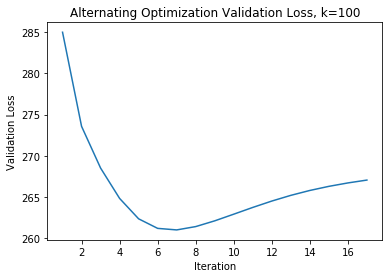

In [33]:
plt.title('Alternating Optimization Validation Loss, k=100')
plt.xlabel('Iteration')
plt.ylabel('Validation Loss')
interval = range(len(val_l_a))
plt.plot(interval[1:], val_l_a[1:])
plt.show()


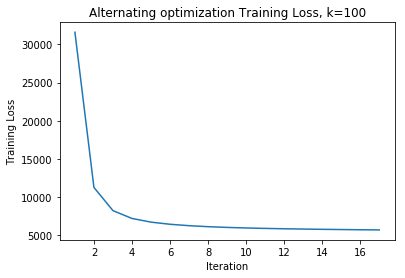

In [34]:
plt.title('Alternating optimization Training Loss, k=100')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
x = range(len(tr_l_a))
plt.plot(x[1:], tr_l_a[1:])
plt.show()

In [35]:
def latent_factor_gradient_descent(M, non_zero_idx, k, val_idx, val_values, 
                                   reg_lambda, learning_rate, batch_size=-1,
                                   max_steps=50000, init='random',
                                   log_every=1000, patience=20,
                                   eval_every=50):
    """
    Perform matrix factorization using gradient descent. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    M                 : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k                 : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda        : float
                        The regularization strength.

    learning_rate     : float
                        Step size of the gradient descent updates.
                        
    batch_size        : int, optional, default: -1
                        (Mini-) batch size. -1 means we perform standard full-sweep gradient descent.
                        If the batch size is >0, use mini batches of this given size.
                        
    max_steps         : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init              : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 10
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.
                        
    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """
       
    ### YOUR CODE HERE ###
            
    np.random.seed(1)
    numb_elements = np.shape(non_zero_idx)[1]
    counter = patience
    best_Q = np.empty([M.shape[0], k])
    best_P = np.empty([k, M.shape[1]])
    Q, P = initialize_Q_P(M, k, init)
    validation_losses =[]
    train_losses =[]
    best = np.inf
    copy_mat = sp.lil_matrix((M.shape[0], M.shape[1]))
    copy_mat[non_zero_idx] = M[non_zero_idx]
    total = 0
    countertime = 0
    step = 0

    while step < max_steps:
        start = time.time()
        if step % eval_every == 0:
            predicted = Q.dot(P)
            train_loss = np.sum(np.square(predicted[nonzero_indices] - M[nonzero_indices]))
            train_losses.append(train_loss)
            validation_loss = math.sqrt(np.sum(np.square(predicted[val_idx] - val_values)))
            validation_losses.append(validation_loss)


            # if validation loss smaller
            if  validation_loss < best:
                best_Q = Q
                best_P = P
                best = validation_loss
                counter = patience
            else:   #decrease patient
                counter = counter - 1
            if counter == 0:    # our patience is enough stop everything
                break

        if step % log_every == 0:
            print("Iteration: " + str(step)+ " , training loss: "+ str(train_loss)+ " validation loss: "+ str(validation_loss ))

        if batch_size == -1:            #all data  size full sweeep
            prediction = sp.lil_matrix((M.shape[0], M.shape[1]))
            prediction[non_zero_idx] = Q.dot(P)[non_zero_idx]
            P = P -  2 * learning_rate / M.shape[0] * (((prediction - copy_mat).T.dot(Q)).T + reg_lambda * P)
            Q = Q -  2 * learning_rate / M.shape[1] * ((prediction - copy_mat).dot(P.T) + reg_lambda * Q)

        if batch_size > 0:     # small batches 
            deltaP = np.zeros([k, M.shape[1]])
            deltaQ = np.zeros([M.shape[0], k])
            indices = np.random.randint(numb_elements, size=batch_size)
            for index in indices:
                diff = Q[non_zero_idx[0][index], :].dot(P[:, non_zero_idx[1][index]]) - copy_mat[non_zero_idx[0][index], non_zero_idx[1][index]]
                deltaP[:, non_zero_idx[1][index]] += diff * Q[non_zero_idx[0][index], :] + reg_lambda * P[:, non_zero_idx[1][index]]
                deltaQ[non_zero_idx[0][index], :] += diff * P[:, non_zero_idx[1][index]] + reg_lambda * Q[non_zero_idx[0][index], :]
            P = P -  learning_rate / batch_size * deltaP
            Q = Q -  learning_rate / batch_size * deltaQ

        end = time.time()
        countertime = countertime + 1
        total = total + (end - start)
        step = step +1
    if step < max_steps:
        converged_after = step - patience * eval_every
    else:
        converged_after = max_steps
    print('Converged after '+ str(converged_after)+' iterations, on average:' + str(total/countertime))
    return best_Q, best_P, validation_losses, train_losses, converged_after


In [36]:
Q_g_sweep, P_g_sweep, val_l_g_sweep, tr_l_g_sweep, conv_g_sweep =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                                   k=30, val_idx=val_idx,
                                                                                                   val_values=val_values_shifted, 
                                                                                                   reg_lambda=1, learning_rate=1e-1,
                                                                                                   init='svd', batch_size=-1,
                                                                                                   max_steps=10000, log_every=20, 
                                                                                                   eval_every=20)

Iteration: 0 , training loss: 301219.2878996459 validation loss: 253.30193458710622
Iteration: 20 , training loss: 292330.49527302105 validation loss: 253.18300604836298
Iteration: 40 , training loss: 285877.94262839697 validation loss: 253.27149731408184
Iteration: 60 , training loss: 280707.4158678399 validation loss: 253.4716682445864
Iteration: 80 , training loss: 276349.3780902206 validation loss: 253.74827684794792
Iteration: 100 , training loss: 272559.50309618254 validation loss: 254.0837490952381
Iteration: 120 , training loss: 269192.27120219293 validation loss: 254.46739736790047
Iteration: 140 , training loss: 266153.22615907795 validation loss: 254.89182755875973
Iteration: 160 , training loss: 263377.23182833195 validation loss: 255.35145980424764
Iteration: 180 , training loss: 260817.28952744202 validation loss: 255.84182732846133
Iteration: 200 , training loss: 258438.26702277912 validation loss: 256.35921250847184
Iteration: 220 , training loss: 256213.14473319883 val

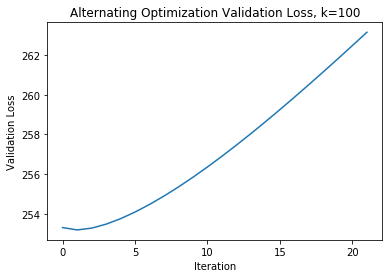

In [37]:
### YOUR PLOTTING CODE HERE ###
plt.title('Alternating Optimization Validation Loss, k=100')
plt.xlabel('Iteration')
plt.ylabel('Validation Loss')
interval = range(len(val_l_g_sweep))
plt.plot(interval[0:], val_l_g_sweep[0:])
plt.show()



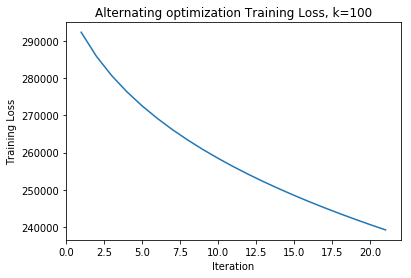

In [38]:
plt.title('Alternating optimization Training Loss, k=100')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
x = range(len(tr_l_g_sweep))
plt.plot(x[1:], tr_l_g_sweep[1:])
plt.show()

In [39]:
Q_g_st, P_g_st, val_l_g_st, tr_l_g_st, conv_g_st = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1, learning_rate=1e-3,
                                                                                   init='svd', batch_size=1,
                                                                                   max_steps=20000, log_every=500, 
                                                                                   eval_every=50)

Iteration: 0 , training loss: 301219.2878996459 validation loss: 253.30193458710622
Iteration: 500 , training loss: 301211.8253803356 validation loss: 253.29139444937306
Iteration: 1000 , training loss: 301207.3487559486 validation loss: 253.290635676256
Converged after 400 iterations, on average:0.016773194244929724


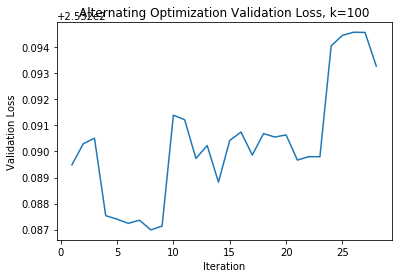

In [40]:
### YOUR PLOTTING CODE HERE ###
plt.title('Alternating Optimization Validation Loss, k=100')
plt.xlabel('Iteration')
plt.ylabel('Validation Loss')
interval = range(len(val_l_g_st))
plt.plot(interval[1:], val_l_g_st[1:])
plt.show()



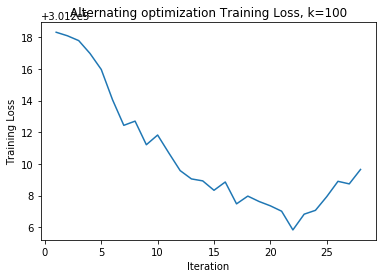

In [42]:
plt.title('Alternating optimization Training Loss, k=100')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
x = range(len(tr_l_g_st))
plt.plot(x[1:], tr_l_g_st[1:])
plt.show()

In [72]:
def parameter_search(M_train, val_idx, val_values):

    batch_sizes = [1, 32, 512, -1]
    lambdas = np.random.rand(3)
    learning_rates = [1, 0.1, 0.01]
    latent_dimensions = [8,15,29]
    best_conf =None
    best_val_loss = np.inf

    for batch in batch_sizes:
        for lmbda in lambdas:
            for learning in learning_rates:
                for dimension in latent_dimensions:
                    curr_conf = (batch, lmbda, learning, dimension)
                    print("Current raining configuration : ["+ str(batch)  + ", "+ str(lmbda ) + ", "+ str(learning) + ", "+ str(dimension)+ "]")
                   
                
                    # search all combination one by on with at most 250 iteration in order to make it quick 
                    Q_g_mb, P_g_mb, val_l_g_mb, tr_l_g_mb, conv_g_mb = latent_factor_gradient_descent(
                        M_shifted, nonzero_indices, 
                        k= dimension, val_idx=val_idx,
                        val_values=val_values_shifted, 
                        reg_lambda=lmbda, learning_rate= learning,
                        init='svd', batch_size=batch,
                        max_steps=250, log_every=250, patience=1,
                        eval_every=250)
                    
                    print("Done. Best validation loss is :" + str( np.min(val_l_g_mb)))
                    
                    if (np.min(val_l_g_mb) < best_val_loss):
                        best_val_loss = np.min(val_l_g_mb)
                        best_conf = curr_conf
                        print("New best configuration is :[ "+ str(batch)  + ", "+ str(lmbda ) + ", "+ str(learning) + ", "+ str(dimension)+ "]")
                    print("---------------------------------------")
    print("Best configuration is {}".format(best_conf))
    return best_conf 

In [73]:
best_configuration = parameter_search(M_train, val_idx, val_values)

Current raining configuration : [1, 0.41738279631790665, 1, 8]
Iteration: 0 , training loss: 323830.051543459 validation loss: 251.8956643133712
Converged after 250 iterations, on average:0.0019572162628173828
Done. Best validation loss is :251.8956643133712
New best configuration is :[ 1, 0.41738279631790665, 1, 8]
---------------------------------------
Current raining configuration : [1, 0.41738279631790665, 1, 15]
Iteration: 0 , training loss: 316267.4316750051 validation loss: 251.85258457713704
Converged after 250 iterations, on average:0.004263307571411133
Done. Best validation loss is :251.85258457713704
New best configuration is :[ 1, 0.41738279631790665, 1, 15]
---------------------------------------
Current raining configuration : [1, 0.41738279631790665, 1, 29]
Iteration: 0 , training loss: 302167.9544396134 validation loss: 253.17487595572948
Converged after 250 iterations, on average:0.010391575813293457
Done. Best validation loss is :253.17487595572948
------------------

Iteration: 0 , training loss: 323830.0515434591 validation loss: 251.8956643133712
Converged after 250 iterations, on average:0.0037421102523803713
Done. Best validation loss is :251.8956643133712
---------------------------------------
Current raining configuration : [32, 0.41738279631790665, 1, 15]
Iteration: 0 , training loss: 316267.4316750051 validation loss: 251.85258457713707
Converged after 250 iterations, on average:0.008045543670654296
Done. Best validation loss is :251.85258457713707
---------------------------------------
Current raining configuration : [32, 0.41738279631790665, 1, 29]
Iteration: 0 , training loss: 302167.95443961344 validation loss: 253.17487595572956
Converged after 250 iterations, on average:0.012300686836242676
Done. Best validation loss is :253.17487595572956
---------------------------------------
Current raining configuration : [32, 0.41738279631790665, 0.1, 8]
Iteration: 0 , training loss: 323830.051543459 validation loss: 251.8956643133712
Converge

Converged after 250 iterations, on average:0.026971829414367675
Done. Best validation loss is :251.8956643133712
---------------------------------------
Current raining configuration : [512, 0.41738279631790665, 1, 15]
Iteration: 0 , training loss: 316267.4316750051 validation loss: 251.85258457713707
Converged after 250 iterations, on average:0.032377949714660646
Done. Best validation loss is :251.85258457713707
---------------------------------------
Current raining configuration : [512, 0.41738279631790665, 1, 29]
Iteration: 0 , training loss: 302167.9544396134 validation loss: 253.17487595572948
Converged after 250 iterations, on average:0.03708948993682861
Done. Best validation loss is :253.17487595572948
---------------------------------------
Current raining configuration : [512, 0.41738279631790665, 0.1, 8]
Iteration: 0 , training loss: 323830.051543459 validation loss: 251.8956643133712
Converged after 250 iterations, on average:0.02725653839111328
Done. Best validation loss i

Converged after 250 iterations, on average:0.9011603679656982
Done. Best validation loss is :251.8956643133712
---------------------------------------
Current raining configuration : [-1, 0.41738279631790665, 1, 15]
Iteration: 0 , training loss: 316267.43167500506 validation loss: 251.85258457713704
Converged after 250 iterations, on average:0.908901099205017
Done. Best validation loss is :251.85258457713704
---------------------------------------
Current raining configuration : [-1, 0.41738279631790665, 1, 29]
Iteration: 0 , training loss: 302167.95443961344 validation loss: 253.17487595572948
Converged after 250 iterations, on average:3.679706377029419
Done. Best validation loss is :253.17487595572948
---------------------------------------
Current raining configuration : [-1, 0.41738279631790665, 0.1, 8]
Iteration: 0 , training loss: 323830.051543459 validation loss: 251.8956643133712
Converged after 250 iterations, on average:0.6935464353561401
Done. Best validation loss is :251.89

In [74]:
print("Best configuration : batch: " + str( best_configuration[0])  +  ", lambda :" + str( best_configuration[1]) + ", learning_rate:" +  str( best_configuration[2])+ ", dimension :" +  str( best_configuration[3]))    


Best configuration : batch: 1, lambda :0.41738279631790665, learning_rate:1, dimension :15


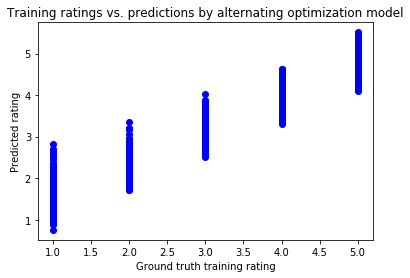

In [78]:


plt.title("Training ratings vs. predictions by alternating optimization model")
plt.xlabel("Ground truth training rating")
plt.ylabel("Predicted rating")
X = (Q_a.dot(P_a) + user_means)
a = np.asarray(M[nonzero_indices]).reshape(-1)
b = np.asarray(X[nonzero_indices]).reshape(-1)
plt.plot(a, b, 'bo')
plt.show() 

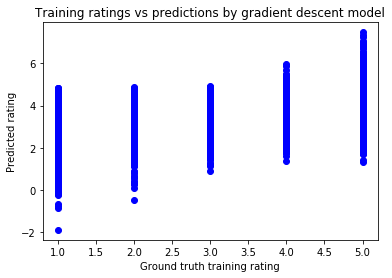

In [81]:
plt.title("Training ratings vs predictions by gradient descent model")
plt.ylabel("Predicted rating")
plt.xlabel("Ground truth training rating")
X = (Q_g_sweep.dot(P_g_sweep) + user_means)

a = np.asarray(M[nonzero_indices]).reshape(-1) 
b = np.asarray(X[nonzero_indices]).reshape(-1)

plt.plot(a, b, 'bo')
plt.show()

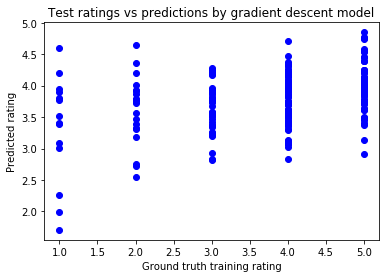

In [88]:
plt.title("Test ratings vs predictions by gradient descent model")
plt.ylabel("Predicted rating")
plt.xlabel("Ground truth training rating")

X = (Q_g_sweep.dot(P_g_sweep) + user_means)

a = np.asarray(test_values).reshape(-1)
b = np.asarray(X[test_idx]).reshape(-1)

plt.plot(a, b, 'bo')
plt.show()

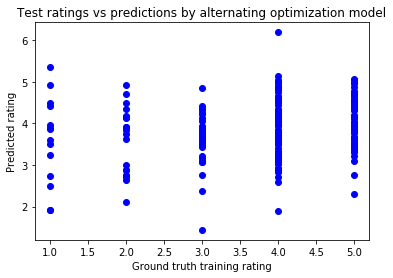

In [87]:
plt.title("Test ratings vs predictions by alternating optimization model")
plt.ylabel("Predicted rating")
plt.xlabel("Ground truth training rating")
X = (Q_a.dot(P_a) + user_means)

a = np.asarray(test_values).reshape(-1)
b = np.asarray(X[test_idx]).reshape(-1)

plt.plot(a, b, 'bo')
plt.show()